# IMPORT

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as trasforma
import torchvision.models as modelli

import os
import copy
import time
import pygame
import sys

# USARE CUDA SE DISPONIBILE

In [2]:
usa_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if usa_cuda else torch.FloatTensor

# MANIPOLAZIONE IMMAGINI

In [3]:
dimensione_immagine = 1024 if usa_cuda else 512

manipolazione = trasforma.Compose([
    trasforma.Resize((dimensione_immagine,dimensione_immagine)),
    trasforma.ToTensor()
])

def carica_immagine(nome_immagine):
    immagine = Image.open(nome_immagine)
    immagine = Variable(manipolazione(immagine))
    #Aggiunge una dimensione al tensore
    immagine = immagine.unsqueeze(0)
    return immagine

immagine_contenuto = carica_immagine("immagini/erika.jpg").type(dtype)
immagine_stile = carica_immagine("immagini/notte.jpg").type(dtype)

assert immagine_contenuto.size() == immagine_stile.size()

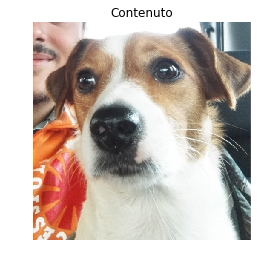

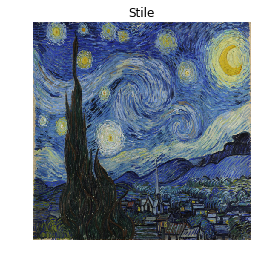

In [4]:
riottieni_immagine = trasforma.ToPILImage() 

if not os.path.exists("immagini_esecuzione"):
    os.makedirs("immagini_esecuzione")

#Attiva modalità interattiva
plt.ion()

def mostra_immagine(tensore, titolo):
    immagine = tensore.clone().cpu()
    #reshape
    immagine = immagine.view(3, dimensione_immagine, dimensione_immagine)
    immagine = riottieni_immagine(immagine)
    immagine.save("immagini_esecuzione/"+titolo+".png")
    plt.imshow(immagine)
    plt.axis("off")
    plt.title(titolo)

plt.figure()
mostra_immagine(immagine_contenuto.data, titolo="Contenuto")

plt.figure()
mostra_immagine(immagine_stile.data, titolo="Stile")

# FUNZIONI PER CALCOLO PERDITA

In [5]:
class PerditaContenuto(nn.Module):
    
    def __init__(self, obiettivo, peso):
        super(PerditaContenuto, self).__init__()
        
        self.obiettivo = obiettivo.detach()*peso
        self.peso = peso
        self.criterio = nn.MSELoss()
        
    def forward(self, input):
        self.perdita = self.criterio(input*self.peso, self.obiettivo)
        self.output = input
        return self.output
    
    def backward(self, retain_graph=True):
        self.perdita.backward(retain_graph=retain_graph)
        return self.perdita

In [6]:
class MatriceGram(nn.Module):

    def forward(self, input):
        dim_batch, num_fmaps, xfmap, yfmap = input.size()  

        feature = input.view(dim_batch * num_fmaps, xfmap * yfmap)  

        gramiana = torch.mm(feature, feature.t())  
        
        #normalizzazione valori dividendo per il numero di elementi in ogni feature map
        return gramiana.div(dim_batch * num_fmaps * xfmap * yfmap)

In [7]:
class PerditaStile(nn.Module):

    def __init__(self, obiettivo, peso):
        super(PerditaStile, self).__init__()
        self.obiettivo = obiettivo.detach() * peso
        self.peso = peso
        self.gramiana = MatriceGram()
        self.criterio = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gramiana(input)
        #moltiplicazione scalare in-place
        self.G.mul_(self.peso)
        self.perdita = self.criterio(self.G, self.obiettivo)
        return self.output

    def backward(self, retain_graph=True):
        self.perdita.backward(retain_graph=retain_graph)
        return self.perdita

# CARICA RETE NEURALE

In [8]:
rete = modelli.vgg19(pretrained=True).features

if usa_cuda:
    rete = rete.cuda()

In [9]:
strati_contenuto_selezionati = ['conv_4']
strati_stile_selezionati = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def get_stile_modello_e_perdite(rete, immagine_stile, immagine_contenuto,
                               peso_stile=1000, peso_contenuto=1,
                               strati_contenuto=strati_contenuto_selezionati,
                               strati_stile=strati_stile_selezionati):
    rete = copy.deepcopy(rete)


    perdite_contenuto = []
    perdite_stile = []
    
    #inizializzazione modello
    modello = nn.Sequential()  
    gramiana = MatriceGram()  

    if usa_cuda:
        modello = modello.cuda()
        gramiana = gramiana.cuda()
    
    #popolazione modello
    i = 1
    for strato in list(rete):
        if isinstance(strato, nn.Conv2d):
            nome = "conv_" + str(i)
            modello.add_module(nome, strato)

            if nome in strati_contenuto:
                obiettivo = modello(immagine_contenuto).clone()
                perdita_contenuto = PerditaContenuto(obiettivo, peso_contenuto)
                modello.add_module("perdita_contenuto_" + str(i), perdita_contenuto)
                perdite_contenuto.append(perdita_contenuto)

            if nome in strati_stile:
                obiettivo_feature = modello(immagine_stile).clone()
                obiettivo_feature_gramiana = gramiana(obiettivo_feature)
                perdita_stile = PerditaStile(obiettivo_feature_gramiana, peso_stile)
                modello.add_module("perdita_stile_" + str(i), perdita_stile)
                perdite_stile.append(perdita_stile)

        if isinstance(strato, nn.ReLU):
            nome = "relu_" + str(i)
            modello.add_module(nome, strato)

            if nome in strati_contenuto:
                obiettivo = modello(immagine_contenuto).clone()
                perdita_contenuto = PerditaContenuto(obiettivo, peso_contenuto)
                modello.add_module("perdita_contenuto_" + str(i), perdita_contenuto)
                perdite_contenuto.append(perdita_contenuto)

            if nome in strati_stile:
                obiettivo_feature = modello(immagine_stile).clone()
                obiettivo_feature_gramiana = gramiana(obiettivo_feature)
                perdita_stile = PerditaStile(obiettivo_feature_gramiana, peso_stile)
                modello.add_module("perdita_stile_" + str(i), perdita_stile)
                perdite_stile.append(perdita_stile)

            i += 1

        if isinstance(strato, nn.MaxPool2d):
            nome = "pool_" + str(i)
            modello.add_module(nome, strato)


    return modello, perdite_stile, perdite_contenuto

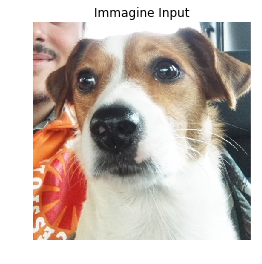

In [10]:
immagine_input = immagine_contenuto.clone()

plt.figure()
mostra_immagine(immagine_input.data, titolo='Immagine Input')

# DISCESA DEL GRADIENTE

In [11]:
def esecuzione_style_transfer(rete, immagine_contenuto, immagine_stile, immagine_input, minuti = 60,
                       peso_stile=1000, peso_contenuto=1):
    
    inizio = time.time()
    timeout = time.time()+60*minuti
    
    print('Costruzione modello in corso...')
    modello, perdite_stile, perdite_contenuto = get_stile_modello_e_perdite(rete,
        immagine_stile, immagine_contenuto, peso_stile, peso_contenuto)
    
    
    parametri_input = nn.Parameter(immagine_input.data)
    ottimizzatore = optim.LBFGS([parametri_input])

    print('Ottimizzazione in corso...')
    esecuzione = [0]
    #VERSIONE BASATA SULLA CONVERGENZA
    #loss_log = [[sys.maxsize,sys.maxsize], [sys.maxsize-1,sys.maxsize-1]]
    #i = 0
    #while abs(loss_log[-2][0]-loss_log[-1][0])+abs(loss_log[-2][1]-loss_log[-1][1]) > precisione or i<2
    while time.time() < timeout :
        
        def avvicinamento():

            parametri_input.data.clamp_(0, 1)
            
            #setta i gradienti di tutti i parametri del modello a 0
            ottimizzatore.zero_grad()
            modello(parametri_input)
            score_stile = 0
            score_contenuto = 0

            for ps in perdite_stile:
                score_stile += ps.backward()
            for pc in perdite_contenuto:
                score_contenuto += pc.backward()

            esecuzione[0] += 1
            #ridondante ma mi accerto che tutto fili liscio
            print("Sto eseguendo...")

            print("esecuzione {}:".format(esecuzione))
            print('Perdita Stile: {:4f} Perdita Contenuto: {:4f}'.format(score_stile.data[0], score_contenuto.data[0]))
            print("Tempo totale trascorso: "+str(time.time()-inizio)+" secondi")
            print()
            
            #loss_log.append([score_stile.data[0],score_contenuto.data[0]])
            
            return score_stile + score_contenuto
        
        ottimizzatore.step(avvicinamento)
        
        #i += 1
        
    parametri_input.data.clamp_(0, 1)

    return parametri_input.data

# ESECUZIONE ALGORITMO

Costruzione modello in corso...
Ottimizzazione in corso...
Sto eseguendo...
esecuzione [1]:
Perdita Stile: 309.458557 Perdita Contenuto: 0.000000
Tempo totale trascorso: 24.063313484191895 secondi

Sto eseguendo...
esecuzione [2]:
Perdita Stile: 309.432404 Perdita Contenuto: 0.000000
Tempo totale trascorso: 38.90956139564514 secondi

Sto eseguendo...
esecuzione [3]:
Perdita Stile: 130.711548 Perdita Contenuto: 0.408720
Tempo totale trascorso: 53.954609632492065 secondi

Sto eseguendo...
esecuzione [4]:
Perdita Stile: 1049.715576 Perdita Contenuto: 3.213197
Tempo totale trascorso: 68.98415541648865 secondi

Sto eseguendo...
esecuzione [5]:
Perdita Stile: 72.062469 Perdita Contenuto: 0.730144
Tempo totale trascorso: 83.92277526855469 secondi

Sto eseguendo...
esecuzione [6]:
Perdita Stile: 54.335960 Perdita Contenuto: 0.944704
Tempo totale trascorso: 98.81802654266357 secondi

Sto eseguendo...
esecuzione [7]:
Perdita Stile: 38.265972 Perdita Contenuto: 1.298511
Tempo totale trascorso: 11

Sto eseguendo...
esecuzione [61]:
Perdita Stile: 2.692251 Perdita Contenuto: 2.173701
Tempo totale trascorso: 924.9165637493134 secondi

Sto eseguendo...
esecuzione [62]:
Perdita Stile: 2.659855 Perdita Contenuto: 2.176730
Tempo totale trascorso: 939.9692904949188 secondi

Sto eseguendo...
esecuzione [63]:
Perdita Stile: 2.613593 Perdita Contenuto: 2.177242
Tempo totale trascorso: 955.0658776760101 secondi

Sto eseguendo...
esecuzione [64]:
Perdita Stile: 2.558871 Perdita Contenuto: 2.175718
Tempo totale trascorso: 970.2173459529877 secondi

Sto eseguendo...
esecuzione [65]:
Perdita Stile: 2.492063 Perdita Contenuto: 2.169483
Tempo totale trascorso: 985.3106796741486 secondi

Sto eseguendo...
esecuzione [66]:
Perdita Stile: 2.438991 Perdita Contenuto: 2.158982
Tempo totale trascorso: 1000.4840743541718 secondi

Sto eseguendo...
esecuzione [67]:
Perdita Stile: 2.401768 Perdita Contenuto: 2.141375
Tempo totale trascorso: 1015.5935971736908 secondi

Sto eseguendo...
esecuzione [68]:
Perdi

Sto eseguendo...
esecuzione [121]:
Perdita Stile: 1.404140 Perdita Contenuto: 1.806809
Tempo totale trascorso: 1836.1761376857758 secondi

Sto eseguendo...
esecuzione [122]:
Perdita Stile: 1.381828 Perdita Contenuto: 1.796168
Tempo totale trascorso: 1851.3094670772552 secondi

Sto eseguendo...
esecuzione [123]:
Perdita Stile: 1.385050 Perdita Contenuto: 1.803719
Tempo totale trascorso: 1866.545538187027 secondi

Sto eseguendo...
esecuzione [124]:
Perdita Stile: 1.357369 Perdita Contenuto: 1.797752
Tempo totale trascorso: 1881.7954506874084 secondi

Sto eseguendo...
esecuzione [125]:
Perdita Stile: 1.344629 Perdita Contenuto: 1.798095
Tempo totale trascorso: 1896.9573197364807 secondi

Sto eseguendo...
esecuzione [126]:
Perdita Stile: 1.316529 Perdita Contenuto: 1.800608
Tempo totale trascorso: 1912.1855216026306 secondi

Sto eseguendo...
esecuzione [127]:
Perdita Stile: 1.291300 Perdita Contenuto: 1.798113
Tempo totale trascorso: 1927.3974676132202 secondi

Sto eseguendo...
esecuzione 

Sto eseguendo...
esecuzione [181]:
Perdita Stile: 0.286106 Perdita Contenuto: 1.789685
Tempo totale trascorso: 2750.831748008728 secondi

Sto eseguendo...
esecuzione [182]:
Perdita Stile: 0.275898 Perdita Contenuto: 1.791741
Tempo totale trascorso: 2765.9738097190857 secondi

Sto eseguendo...
esecuzione [183]:
Perdita Stile: 0.265247 Perdita Contenuto: 1.788939
Tempo totale trascorso: 2781.2232427597046 secondi

Sto eseguendo...
esecuzione [184]:
Perdita Stile: 0.261575 Perdita Contenuto: 1.787926
Tempo totale trascorso: 2796.4712042808533 secondi

Sto eseguendo...
esecuzione [185]:
Perdita Stile: 0.259139 Perdita Contenuto: 1.782258
Tempo totale trascorso: 2811.7329816818237 secondi

Sto eseguendo...
esecuzione [186]:
Perdita Stile: 0.253002 Perdita Contenuto: 1.783470
Tempo totale trascorso: 2826.9515686035156 secondi

Sto eseguendo...
esecuzione [187]:
Perdita Stile: 0.247425 Perdita Contenuto: 1.782982
Tempo totale trascorso: 2842.279030561447 secondi

Sto eseguendo...
esecuzione [

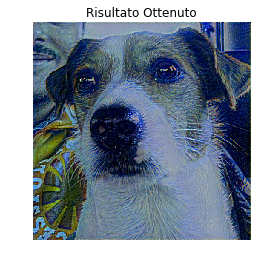

CPU times: user 1h 17min 20s, sys: 5min 34s, total: 1h 22min 55s
Wall time: 1h 50s


In [12]:
%%time
opera = esecuzione_style_transfer(rete, immagine_contenuto, immagine_stile, immagine_input)

plt.figure()
mostra_immagine(opera, titolo="Risultato Ottenuto")

plt.ioff()
plt.show()
pygame.init()
#Squilla quando ha finito
pygame.mixer.music.load('squillo.mp3')
pygame.mixer.music.play(-1)

In [14]:
#pygame.mixer.music.stop()